<a href="https://colab.research.google.com/github/YTW0415/Kaggle_Basketball/blob/main/Kaggle_basket_20230303.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset 불러오기 - 태원's github 주소에서 불러오는거니 실제 수상 시 없애고 자기 깃허브 주소로 변경 바랍니다

In [103]:
!git clone https://github.com/YTW0415/Kaggle_Basketball.git

fatal: destination path 'Kaggle_Basketball' already exists and is not an empty directory.


# Adapting the 2nd Place Solution of the 2021 NCAAW Competition

- Solution write-up is available here : https://www.kaggle.com/c/ncaaw-march-mania-2021/discussion/230705
- 2nd place code : https://www.kaggle.com/theoviel/2nd-place-ncaaw-2021?scriptVersionId=58780991
- It was adapted from this notebook : https://www.kaggle.com/theoviel/ncaa-starter-the-simpler-the-better 

**Changes :**
- Build one model for both Men and Women
- Update metric to MSE

In [2]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

pd.set_option('display.max_columns', None)

In [3]:
DATA_PATH = '/content/Kaggle_Basketball/march-machine-learning-mania-2023/'

for filename in sorted(os.listdir(DATA_PATH)):
    print(filename)

Cities.csv
Conferences.csv
MConferenceTourneyGames.csv
MGameCities.csv
MMasseyOrdinals.csv
MNCAATourneyCompactResults.csv
MNCAATourneyDetailedResults.csv
MNCAATourneySeedRoundSlots.csv
MNCAATourneySeeds.csv
MNCAATourneySlots.csv
MRegularSeasonCompactResults.csv
MRegularSeasonDetailedResults.csv
MSeasons.csv
MSecondaryTourneyCompactResults.csv
MSecondaryTourneyTeams.csv
MTeamCoaches.csv
MTeamConferences.csv
MTeamSpellings.csv
MTeams.csv
SampleSubmission2023.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneyDetailedResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WRegularSeasonDetailedResults.csv
WSeasons.csv
WTeamConferences.csv
WTeamSpellings.csv
WTeams.csv


# Data preparation

## Seeds
> This file identifies the seeds for all teams in each NCAA® tournament, for all seasons of historical data. Thus, there are between 64-68 rows for each year, depending on whether there were any play-in games and how many there were. In recent years the structure has settled at 68 total teams, with four "play-in" games leading to the final field of 64 teams entering Round 1 on Thursday of the first week (by definition, that is DayNum=136 each season). We will not know the seeds of the respective tournament teams, or even exactly which 68 teams it will be, until Selection Sunday on March 15, 2020 (DayNum=132).

> The seed is a 3/4-character :
- First character : Region (W, X, Y, or Z)
- Next two digits : Seed within the region (01 to 16)
- Last character (optional): Distinguishes teams between play-ins ( a or b)

In [4]:
df_seeds = pd.concat([
    pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv"),
    pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv"),
], ignore_index=True)
    
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [5]:
df_seeds['Seed'].value_counts()

W01     61
X14     61
Y01     61
Y02     61
Y03     61
        ..
Z13a     1
Z13b     1
Y12a     1
Y12b     1
Z14b     1
Name: Seed, Length: 90, dtype: int64

## Season results
> This file identifies the game-by-game results for many seasons of historical data, starting with the 1985 season (the first year the NCAA® had a 64-team tournament). For each season, the file includes all games played from DayNum 0 through 132. It is important to realize that the "Regular Season" games are simply defined to be all games played on DayNum=132 or earlier (DayNum=132 is Selection Sunday, and there are always a few conference tournament finals actually played early in the day on Selection Sunday itself). Thus a game played on or before Selection Sunday will show up here whether it was a pre-season tournament, a non-conference game, a regular conference game, a conference tournament game, or whatever.

In [6]:
df_season_results = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonCompactResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv"),
], ignore_index=True)

df_season_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [7]:
df_season_results['ScoreGap'] = df_season_results['WScore'] - df_season_results['LScore']

In [8]:
df_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,ScoreGap
0,1985,20,1228,81,1328,64,17
1,1985,25,1106,77,1354,70,7
2,1985,25,1112,63,1223,56,7
3,1985,25,1165,70,1432,54,16
4,1985,25,1192,86,1447,74,12


### Features 
For each team at each season, I compute : 
- Number of wins
- Number of losses
- Average score gap of wins
- Average score gap of losses

And use the following features : 
- Win Ratio
- Average score gap

In [9]:
num_win = df_season_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})

In [10]:
num_loss = df_season_results.groupby(['Season', 'LTeamID']).count()
num_loss = num_loss.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLosses", "LTeamID": "TeamID"})

In [11]:
gap_win = df_season_results.groupby(['Season', 'WTeamID']).mean().reset_index()
gap_win = gap_win[['Season', 'WTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapWins", "WTeamID": "TeamID"})

In [12]:
gap_loss = df_season_results.groupby(['Season', 'LTeamID']).mean().reset_index()
gap_loss = gap_loss[['Season', 'LTeamID', 'ScoreGap']].rename(columns={"ScoreGap": "GapLosses", "LTeamID": "TeamID"})

Merge

In [13]:
df_features_season_w = df_season_results.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_features_season_l = df_season_results.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [14]:
df_features_season = pd.concat([df_features_season_w, df_features_season_l], axis=0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

In [15]:
df_features_season = df_features_season.merge(num_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(num_loss, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_win, on=['Season', 'TeamID'], how='left')
df_features_season = df_features_season.merge(gap_loss, on=['Season', 'TeamID'], how='left')

In [16]:
df_features_season.fillna(0, inplace=True)  

In [17]:
df_features_season

,Season,TeamID,NumWins,NumLosses,GapWins,GapLosses
0,1985,1102,5.0,19.0,10.000000,9.947368
1,1985,1103,9.0,14.0,7.555556,9.857143
2,1985,1104,21.0,9.0,13.190476,4.777778
3,1985,1106,10.0,14.0,9.500000,13.285714
4,1985,1108,19.0,6.0,13.842105,10.666667
...,...,...,...,...,...,...
21423,2023,3473,1.0,22.0,9.000000,19.318182
21424,2023,3474,5.0,18.0,10.200000,19.888889
21425,2023,3475,8.0,16.0,13.875000,11.625000
21426,2023,3476,7.0,19.0,10.571429,13.368421


Compute features

In [18]:
df_features_season['WinRatio'] = df_features_season['NumWins'] / (df_features_season['NumWins'] + df_features_season['NumLosses'])
df_features_season['GapAvg'] = (
    (df_features_season['NumWins'] * df_features_season['GapWins'] - 
    df_features_season['NumLosses'] * df_features_season['GapLosses'])
    / (df_features_season['NumWins'] + df_features_season['NumLosses'])
)

In [19]:
df_features_season.drop(['NumWins', 'NumLosses', 'GapWins', 'GapLosses'], axis=1, inplace=True)

## Season Results - detail

- WFGM - field goals made (by the winning team)
- WFGA - field goals attempted (by the winning team)
- WFGM3 - three pointers made (by the winning team)
- WFGA3 - three pointers attempted (by the winning team)
- WFTM - free throws made (by the winning team)
- WFTA - free throws attempted (by the winning team)
- WOR - offensive rebounds (pulled by the winning team)
- WDR - defensive rebounds (pulled by the winning team)
- WAst - assists (by the winning team)
- WTO - turnovers committed (by the winning team)
- WStl - steals (accomplished by the winning team)
- WBlk - blocks (accomplished by the winning team)
- WPF - personal fouls committed (by the winning team)

In [64]:
regseason_detail_df = pd.concat([
    pd.read_csv(DATA_PATH + "MRegularSeasonDetailedResults.csv"),
    pd.read_csv(DATA_PATH + "WRegularSeasonDetailedResults.csv"),
], ignore_index=True)

regseason_detail_df.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [65]:
regseason_detail_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176836,2023,113,3268,96,3234,68,34,71,14,26,14,15,11,23,19,11,15,1,14,23,66,11,38,11,15,18,19,14,24,5,3,14
176837,2023,113,3385,69,3163,64,23,63,9,18,14,18,12,26,14,12,4,6,18,22,62,8,21,12,15,11,25,14,12,5,7,19
176838,2023,113,3416,57,3396,53,19,60,4,17,15,27,13,32,9,17,3,7,14,16,70,7,26,14,17,16,19,5,9,10,9,20
176839,2023,113,3437,67,3177,64,24,67,8,23,11,15,10,31,19,14,7,9,10,26,77,4,19,8,11,21,26,13,12,9,2,14


In [66]:
win_team_only = regseason_detail_df.drop(['LTeamID','WAst','LAst','LStl','WStl','LBlk','WBlk','LPF','WPF','DayNum'], axis=1)
win_team_only.rename(columns={'WTeamName': 'TeamName'}, inplace=True)
win_team_only.rename(columns={'WTeamID': 'TeamID'}, inplace=True)

team_factors_list = ['Score','FGM','FGA','FGA3','FGM3','TO','FTM','FTA','RankPOM']
for factor in team_factors_list:
    win_team_only.rename(columns={'W'+factor: factor}, inplace=True)
    win_team_only.rename(columns={'L'+factor: 'Opponent'+factor}, inplace=True)

win_team_only['wins'] = 1 

win_team_only = win_team_only[['Season','TeamID','wins','Score','OpponentScore','FGM','FGA','OpponentFGM','OpponentFGA','FGM3','FGA3','OpponentFGM3','OpponentFGA3','FTM','FTA','OpponentFTM','OpponentFTA','TO','OpponentTO']]

In [67]:
loss_team_only = regseason_detail_df.drop(['WTeamID','WAst','LAst','LStl','WStl','LBlk','WBlk','LPF','WPF','DayNum'], axis=1)
loss_team_only.rename(columns={'LTeamName': 'TeamName'}, inplace=True)
loss_team_only.rename(columns={'LTeamID': 'TeamID'}, inplace=True)

for factor in team_factors_list:
    loss_team_only.rename(columns={'L'+factor: factor}, inplace=True)
    loss_team_only.rename(columns={'W'+factor: 'Opponent'+factor}, inplace=True)

loss_team_only['wins'] = 0

loss_team_only = loss_team_only[['Season','TeamID','wins','Score','OpponentScore','FGM','FGA','OpponentFGM','OpponentFGA','FGM3','FGA3','OpponentFGM3','OpponentFGA3','FTM','FTA','OpponentFTM','OpponentFTA','TO','OpponentTO']]

In [68]:
reg_season_all = win_team_only.append(loss_team_only)

In [69]:
reg_season_all['TOmargin'] = reg_season_all['TO']-reg_season_all['OpponentTO']

reg_season_all['FG'] = reg_season_all['FGM']/reg_season_all['FGA']
reg_season_all['FGopponent'] = reg_season_all['OpponentFGM']/reg_season_all['OpponentFGA']

reg_season_all['FG3'] = reg_season_all['FGM3']/reg_season_all['FGA3']
reg_season_all['FG3opponent'] = reg_season_all['OpponentFGM3']/reg_season_all['OpponentFGA3']

reg_season_all['FT'] = reg_season_all['FTM']/reg_season_all['FTA']

In [70]:
reg_season_all = reg_season_all.drop(['TO','OpponentTO','FGM','FGA','OpponentFGA','OpponentFGM','FGM3','FGA3','OpponentFGM3','OpponentFGA3','FTM','FTA','OpponentFTM','OpponentFTA'], axis=1)

In [71]:
reg_season_means = reg_season_all.groupby(['TeamID','Season']).mean().reset_index()

In [72]:
reg_season_means = reg_season_means.drop(['wins'], axis=1)

In [73]:
reg_season_sum = reg_season_all.groupby(['TeamID','Season']).sum().reset_index()

In [74]:
reg_season_sum = reg_season_sum.drop(['Score','OpponentScore','TOmargin','FG','FG3','FGopponent','FG3opponent','FT'], axis=1)

In [75]:
regseason_df = pd.merge(reg_season_means, reg_season_sum, left_on=['TeamID','Season'], right_on = ['TeamID','Season'], how='left')

In [76]:
regseason_df.head()

,TeamID,Season,Score,OpponentScore,TOmargin,FG,FGopponent,FG3,FG3opponent,FT,wins
0,1101,2014,63.142857,78.619048,2.857143,0.410184,0.510776,0.380275,0.369975,0.758031,2
1,1101,2015,61.000000,71.857143,-0.642857,0.407501,0.493864,0.381507,0.372684,0.736328,7
2,1101,2016,69.851852,76.259259,-0.037037,0.442606,0.493308,0.364517,0.366441,0.701402,9
3,1101,2017,67.880000,72.640000,-0.320000,0.457867,0.463728,0.371026,0.354196,0.640438,9
4,1101,2018,70.666667,72.814815,-1.074074,0.452366,0.458319,0.327240,0.316082,0.705605,12


## Tourney results

> This file identifies the game-by-game NCAA® tournament results for all seasons of historical data. The data is formatted exactly like the MRegularSeasonCompactResults data. All games will show up as neutral site (so WLoc is always N). Note that this tournament game data also includes the play-in games (which always occurred on day 134/135) for those years that had play-in games. Thus each season you will see between 63 and 67 games listed, depending on how many play-in games there were.

In [77]:
df_tourney_results = pd.concat([
    pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv"),
    pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv"),
], ignore_index=True)
df_tourney_results.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [78]:
df_tourney_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1998,137,3104,94,3422,46
1,1998,137,3112,75,3365,63
2,1998,137,3163,93,3193,52
3,1998,137,3198,59,3266,45
4,1998,137,3203,74,3208,72
...,...,...,...,...,...,...
3895,2022,146,1242,76,1274,50
3896,2022,146,1314,69,1389,49
3897,2022,152,1242,81,1437,65
3898,2022,152,1314,81,1181,77


## FiveThirtyEight Ratings
> Not available yet !

In [79]:
# df_538 = pd.read_csv("../input/ncaa-men-538-team-ratings/538ratingsMen.csv")
# df_538.drop('TeamName', axis=1, inplace=True)
# df_538.head()

## Kenpom

https://github.com/harmkenn/Python_Madness_2023/blob/58ed1e5876817bf4e65ba4bf05b59fb3fa1e4cfd/notebooks/step01_aScrapeKenPom.ipynb

In [80]:
# # Grab KenPom 2008 to 2022

# from urllib.request import Request, urlopen
# from bs4 import BeautifulSoup
# import pandas as pd
# import numpy as np
# from tqdm import tqdm

# season = np.arange(2008,2023,1)
# allkp = pd.DataFrame(columns = ['Year','Team','Conf','AdjEM','AdjO','AdjD','AdjT','SOSEM','SOSO','SOSD'])
# for y in season:
#     req = Request(
#         url=f'https://kenpom.com/index.php?y={y}', 
#         headers={'User-Agent': 'Mozilla/5.0'}
#     )
#     webpage = urlopen(req).read()
#     soup =BeautifulSoup(webpage, 'html.parser')

#     table = soup.find('table', class_=None)
    
#     for row in tqdm(table.tbody.find_all('tr')):    
#         # Find all data for each column
#         columns = row.find_all('td')
        
#         if(columns != []):
            
#             Team = columns[1].text.strip()
#             Conf = columns[2].text.strip()
            
#             AdjEM = columns[4].text.strip()
#             AdjO = columns[5].text.strip()
#             AdjD = columns[7].text.strip()
#             AdjT = columns[9].text.strip()
#             SOSEM = columns[13].text.strip()
#             SOSO = columns[15].text.strip()
#             SOSD = columns[17].text.strip()
#             newrow = [y,Team,Conf,AdjEM,AdjO,AdjD,AdjT,SOSEM,SOSO,SOSD]
#             allkp.loc[len(allkp)]=newrow
#             #newrow = pd.DataFrame({'Year':2008,'Team': Team,'Conf':Conf,'AdjEM':AdjEM,'AdjO':AdjO,'AdjD':AdjD,'AdjT':AdjT,'SOSEM':SOSEM,'SOSO':SOSO,'SOSD':SOSD})
#             #allkp = pd.concat(allkp,newrow)
#             allkp['Team'] = allkp['Team'].str.replace('\d+','',regex=True).str.replace('*','',regex=True).str.rstrip()

# allkp.to_csv('step01_kenpom0823.csv',index=False)

In [93]:
# # Grab KenPom 2023

# from urllib.request import Request, urlopen
# from bs4 import BeautifulSoup
# import pandas as pd
# import numpy as np


# allkp = pd.read_csv('step01_kenpom0823.csv')
# allkp = allkp[allkp['Year']!=2023]
# y = 2023

# req = Request(
#     url=f'https://kenpom.com/index.php?y={y}', 
#     headers={'User-Agent': 'Mozilla/5.0'}
# )
# webpage = urlopen(req).read()
# soup =BeautifulSoup(webpage, 'html.parser')

# table = soup.find('table', class_=None)

# for row in table.tbody.find_all('tr'):    
#     # Find all data for each column
#     columns = row.find_all('td')
    
#     if(columns != []):
        
#         Team = columns[1].text.strip()
#         Conf = columns[2].text.strip()
        
#         AdjEM = columns[4].text.strip()
#         AdjO = columns[5].text.strip()
#         AdjD = columns[7].text.strip()
#         AdjT = columns[9].text.strip()
#         SOSEM = columns[13].text.strip()
#         SOSO = columns[15].text.strip()
#         SOSD = columns[17].text.strip()
#         newrow = [y,Team,Conf,AdjEM,AdjO,AdjD,AdjT,SOSEM,SOSO,SOSD]
#         allkp.loc[len(allkp)]=newrow
#         #newrow = pd.DataFrame({'Year':2008,'Team': Team,'Conf':Conf,'AdjEM':AdjEM,'AdjO':AdjO,'AdjD':AdjD,'AdjT':AdjT,'SOSEM':SOSEM,'SOSO':SOSO,'SOSD':SOSD})
#         #allkp = pd.concat(allkp,newrow)
#         allkp['Team'] = allkp['Team'].str.replace('\d+','',regex=True).str.replace('*','',regex=True).str.rstrip()


# allkp.to_csv('step01_kenpom0823.csv',index=False)

In [ ]:
kp_df = allkp[['Team','Conf','AdjEM','AdjO','AdjD','Year']]

In [129]:
teams_df = pd.read_csv(DATA_PATH + 'MTeamSpellings.csv', encoding = 'cp949')

In [130]:
teams_df

,TeamNameSpelling,TeamID
0,a&m-corpus chris,1394
1,a&m-corpus christi,1394
2,abilene chr,1101
3,abilene christian,1101
4,abilene-christian,1101
...,...,...
1159,youngstown st,1464
1160,youngstown st.,1464
1161,youngstown state,1464
1162,youngstown-st,1464


# Feature Engineering

## Train data

In [81]:
df = df_tourney_results.copy()
df = df[df['Season'] >= 2012].reset_index(drop=True)

df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,2012,138,3116,72,3173,55
1,2012,138,3163,83,3341,47
2,2012,138,3177,59,3140,55
3,2012,138,3211,86,3353,73
4,2012,138,3243,67,3343,64


### Seeds
- `SeedW` is the seed of the winning team
- `SeedL` is the seed of the losing team

In [82]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'WTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedW'})

In [83]:
df = pd.merge(
    df, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'LTeamID'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedL'})

In [84]:
def treat_seed(seed):
    return int(re.sub("[^0-9]", "", seed))

In [85]:
df['SeedW'] = df['SeedW'].apply(treat_seed)
df['SeedL'] = df['SeedL'].apply(treat_seed)

In [86]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2012,138,3116,72,3173,55,6,11
1,2012,138,3163,83,3341,47,1,16
2,2012,138,3177,59,3140,55,7,10
3,2012,138,3211,86,3353,73,11,6
4,2012,138,3243,67,3343,64,8,9


### Season Stats
- `WinRatioW` is the win ratio of the winning team during the season
- `WinRatioL` is the win ratio of the losing team during the season

In [87]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsW',
    'NumLosses': 'NumLossesW',
    'GapWins': 'GapWinsW',
    'GapLosses': 'GapLossesW',
    'WinRatio': 'WinRatioW',
    'GapAvg': 'GapAvgW',
}).drop(columns='TeamID', axis=1)

In [88]:
df = pd.merge(
    df,
    df_features_season,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsL',
    'NumLosses': 'NumLossesL',
    'GapWins': 'GapWinsL',
    'GapLosses': 'GapLossesL',
    'WinRatio': 'WinRatioL',
    'GapAvg': 'GapAvgL',
}).drop(columns='TeamID', axis=1)

### Season Stats detail

In [89]:
df = pd.merge(
    df,
    regseason_df,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginW',
    'FG': 'FGW',
    'FGopponent': 'FGopponentW',
    'FG3': 'FG3W',
    'FG3opponent': 'FG3opponentW',
    'FT': 'FTW',
}).drop(columns='TeamID', axis=1)

In [90]:
df = pd.merge(
    df,
    regseason_df,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginL',
    'FG': 'FGL',
    'FGopponent': 'FGopponentL',
    'FG3': 'FG3L',
    'FG3opponent': 'FG3opponentL',
    'FT': 'FTL',
}).drop(columns='TeamID', axis=1)

### FiveThirtyEight Ratings
- `538ratingW` is the rating of the winning team during the season
- `538ratingL` is the rating of the losing team during the season

In [91]:
# df = pd.merge(
#     df,
#     df_538,
#     how='left',
#     left_on=['Season', 'WTeamID'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingW'})

In [92]:
# df = pd.merge(
#     df, 
#     df_538, 
#     how='left', 
#     left_on=['Season', 'LTeamID'], 
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingL'})

In [93]:
# df.head()

### Add symetrical
- Right now our data only consists of won matches
- We duplicate our data, get rid of the winner loser 

In [94]:
def add_loosing_matches(df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "ScoreA", 
        "LTeamID" : "TeamIdB",
        "LScore": "ScoreB",
     }
    win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
    win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "ScoreB", 
        "LTeamID" : "TeamIdA",
        "LScore": "ScoreA",
    }
    lose_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
    lose_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})
    
    win_df = df.copy()
    lose_df = df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], axis=0, sort=False)

In [95]:
df = add_loosing_matches(df)

In [96]:
df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,Score_x,OpponentScore_x,TOmarginA,FGA,FGopponentA,FG3A,FG3opponentA,FTA,wins_x,Score_y,OpponentScore_y,TOmarginB,FGB,FGopponentB,FG3B,FG3opponentB,FTB,wins_y
0,2012,138,3116,72,3173,55,6,11,0.741935,9.903226,0.793103,11.000000,62.233333,52.533333,-4.033333,0.387796,0.373822,0.298807,0.262896,0.647599,22,70.655172,59.655172,-4.068966,0.394796,0.381147,0.304681,0.293307,0.753695,23
1,2012,138,3163,83,3341,47,1,16,0.878788,30.575758,0.516129,-0.548387,76.242424,45.666667,-5.121212,0.476862,0.298184,0.360496,0.233323,0.737482,29,59.928571,61.714286,-2.357143,0.381030,0.405191,0.304213,0.320870,0.676006,13
2,2012,138,3177,59,3140,55,7,10,0.687500,7.000000,0.806452,13.322581,73.187500,66.187500,-1.687500,0.439532,0.400222,0.338742,0.312290,0.739886,22,71.032258,57.709677,-0.419355,0.441381,0.346211,0.348731,0.278607,0.745067,25
3,2012,138,3211,86,3353,73,11,6,0.838710,13.645161,0.709677,6.064516,75.548387,61.903226,-4.258065,0.446175,0.391382,0.316735,0.328924,0.733224,26,60.233333,54.633333,-1.500000,0.404982,0.348191,0.285271,0.281239,0.677534,21
4,2012,138,3243,67,3343,64,8,9,0.593750,1.093750,0.857143,19.500000,57.781250,56.687500,-2.125000,0.383950,0.382510,0.283457,0.271510,0.687319,19,72.321429,52.821429,-3.357143,0.431012,0.355883,0.315618,0.269755,0.700635,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,2022,146,1274,50,1242,76,10,1,0.696970,3.787879,0.823529,10.441176,78.588235,68.147059,-3.909091,0.479677,0.469019,0.347730,0.348951,0.742944,28,74.818182,71.030303,-0.058824,0.481691,0.420758,0.356891,0.297703,0.723683,23
1299,2022,146,1389,49,1314,69,15,8,0.620690,3.931034,0.727273,5.787879,77.515152,71.727273,-0.103448,0.426395,0.390789,0.346832,0.291667,0.687427,24,66.172414,62.241379,1.666667,0.454507,0.434553,0.362980,0.357387,0.767779,18
1300,2022,152,1437,65,1242,81,2,1,0.787879,9.545455,0.823529,10.441176,78.588235,68.147059,-2.333333,0.441174,0.408423,0.365867,0.308943,0.812341,28,72.636364,63.090909,-0.058824,0.481691,0.420758,0.356891,0.297703,0.723683,26
1301,2022,152,1181,77,1314,81,2,8,0.823529,13.029412,0.727273,5.787879,77.515152,71.727273,-0.588235,0.489333,0.418269,0.359057,0.300205,0.728984,24,80.176471,67.147059,1.666667,0.454507,0.434553,0.362980,0.357387,0.767779,28


### Differences
- We compute the difference between the team for each feature.
- This helps further assessing how better (or worse) team A is from team B

In [97]:
cols_to_diff = [
    'Seed', 'WinRatio', 'GapAvg', # '538rating'
    'FG','FG3','FT','TOmargin' # Custom stat
]

for col in cols_to_diff:
    df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

## Test Data

### Preparing

In [98]:
df_test = pd.read_csv(DATA_PATH + "SampleSubmission2023.csv")

In [99]:
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [100]:
df_test

,ID,Pred,Season,TeamIdA,TeamIdB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106
...,...,...,...,...,...
130678,2023_3474_3476,0.5,2023,3474,3476
130679,2023_3474_3477,0.5,2023,3474,3477
130680,2023_3475_3476,0.5,2023,3475,3476
130681,2023_3475_3477,0.5,2023,3475,3477


### Seeds
- Seeds are not released yet, so I fill missing values with "W01"

In [101]:
df_test = pd.merge(
    df_test,
    df_seeds,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedA'}).fillna('W01')

In [102]:
df_test = pd.merge(
    df_test, 
    df_seeds, 
    how='left', 
    left_on=['Season', 'TeamIdB'], 
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed': 'SeedB'}).fillna('W01')

In [103]:
df_test['SeedA'] = df_test['SeedA'].apply(treat_seed)
df_test['SeedB'] = df_test['SeedB'].apply(treat_seed)

### Season Stats

In [104]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsA',
    'NumLosses': 'NumLossesA',
    'GapWins': 'GapWinsA',
    'GapLosses': 'GapLossesA',
    'WinRatio': 'WinRatioA',
    'GapAvg': 'GapAvgA',
}).drop(columns='TeamID', axis=1)

In [105]:
df_test = pd.merge(
    df_test,
    df_features_season,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins': 'NumWinsB',
    'NumLosses': 'NumLossesB',
    'GapWins': 'GapWinsB',
    'GapLosses': 'GapLossesB',
    'WinRatio': 'WinRatioB',
    'GapAvg': 'GapAvgB',
}).drop(columns='TeamID', axis=1)

#### Season detail

In [106]:
df_test = pd.merge(
    df_test,
    regseason_df,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginA',
    'FG': 'FGA',
    'FGopponent': 'FGopponentA',
    'FG3': 'FG3A',
    'FG3opponent': 'FG3opponentA',
    'FT': 'FTA',
}).drop(columns='TeamID', axis=1)

In [107]:
df_test = pd.merge(
    df_test,
    regseason_df,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'TOmargin': 'TOmarginB',
    'FG': 'FGB',
    'FGopponent': 'FGopponentB',
    'FG3': 'FG3B',
    'FG3opponent': 'FG3opponentB',
    'FT': 'FTB',
}).drop(columns='TeamID', axis=1)

### Ratings

In [108]:
# df_test = pd.merge(
#     df_test,
#     df_538,
#     how='left',
#     left_on=['Season', 'TeamIdA'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingA'})

In [109]:
# df_test = pd.merge(
#     df_test,
#     df_538,
#     how='left',
#     left_on=['Season', 'TeamIdB'],
#     right_on=['Season', 'TeamID']
# ).drop('TeamID', axis=1).rename(columns={'538rating': '538ratingB'})

### Differences

In [110]:
for col in cols_to_diff:
    df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

## Target

In [111]:
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

In [112]:
df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,Score_x,OpponentScore_x,TOmarginA,FGA,FGopponentA,FG3A,FG3opponentA,FTA,wins_x,Score_y,OpponentScore_y,TOmarginB,FGB,FGopponentB,FG3B,FG3opponentB,FTB,wins_y,SeedDiff,WinRatioDiff,GapAvgDiff,FGDiff,FG3Diff,FTDiff,TOmarginDiff,ScoreDiff,WinA
0,2012,138,3116,72,3173,55,6,11,0.741935,9.903226,0.793103,11.000000,62.233333,52.533333,-4.033333,0.387796,0.373822,0.298807,0.262896,0.647599,22,70.655172,59.655172,-4.068966,0.394796,0.381147,0.304681,0.293307,0.753695,23,-5,-0.051168,-1.096774,-0.007000,-0.005874,-0.106095,0.035632,17,1
1,2012,138,3163,83,3341,47,1,16,0.878788,30.575758,0.516129,-0.548387,76.242424,45.666667,-5.121212,0.476862,0.298184,0.360496,0.233323,0.737482,29,59.928571,61.714286,-2.357143,0.381030,0.405191,0.304213,0.320870,0.676006,13,-15,0.362659,31.124145,0.095833,0.056283,0.061476,-2.764069,36,1
2,2012,138,3177,59,3140,55,7,10,0.687500,7.000000,0.806452,13.322581,73.187500,66.187500,-1.687500,0.439532,0.400222,0.338742,0.312290,0.739886,22,71.032258,57.709677,-0.419355,0.441381,0.346211,0.348731,0.278607,0.745067,25,-3,-0.118952,-6.322581,-0.001849,-0.009989,-0.005180,-1.268145,4,1
3,2012,138,3211,86,3353,73,11,6,0.838710,13.645161,0.709677,6.064516,75.548387,61.903226,-4.258065,0.446175,0.391382,0.316735,0.328924,0.733224,26,60.233333,54.633333,-1.500000,0.404982,0.348191,0.285271,0.281239,0.677534,21,5,0.129032,7.580645,0.041194,0.031463,0.055690,-2.758065,13,1
4,2012,138,3243,67,3343,64,8,9,0.593750,1.093750,0.857143,19.500000,57.781250,56.687500,-2.125000,0.383950,0.382510,0.283457,0.271510,0.687319,19,72.321429,52.821429,-3.357143,0.431012,0.355883,0.315618,0.269755,0.700635,24,-1,-0.263393,-18.406250,-0.047062,-0.032161,-0.013315,1.232143,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,2022,146,1274,50,1242,76,10,1,0.696970,3.787879,0.823529,10.441176,78.588235,68.147059,-3.909091,0.479677,0.469019,0.347730,0.348951,0.742944,28,74.818182,71.030303,-0.058824,0.481691,0.420758,0.356891,0.297703,0.723683,23,9,-0.126560,-6.653298,-0.002013,-0.009161,0.019261,-3.850267,-26,0
1299,2022,146,1389,49,1314,69,15,8,0.620690,3.931034,0.727273,5.787879,77.515152,71.727273,-0.103448,0.426395,0.390789,0.346832,0.291667,0.687427,24,66.172414,62.241379,1.666667,0.454507,0.434553,0.362980,0.357387,0.767779,18,7,-0.106583,-1.856844,-0.028112,-0.016148,-0.080351,-1.770115,-20,0
1300,2022,152,1437,65,1242,81,2,1,0.787879,9.545455,0.823529,10.441176,78.588235,68.147059,-2.333333,0.441174,0.408423,0.365867,0.308943,0.812341,28,72.636364,63.090909,-0.058824,0.481691,0.420758,0.356891,0.297703,0.723683,26,1,-0.035651,-0.895722,-0.040517,0.008975,0.088658,-2.274510,-16,0
1301,2022,152,1181,77,1314,81,2,8,0.823529,13.029412,0.727273,5.787879,77.515152,71.727273,-0.588235,0.489333,0.418269,0.359057,0.300205,0.728984,24,80.176471,67.147059,1.666667,0.454507,0.434553,0.362980,0.357387,0.767779,28,-6,0.096257,7.241533,0.034826,-0.003923,-0.038795,-2.254902,-4,0


# Modeling

In [132]:
features = [
    'SeedA', 'SeedB',
    'SeedDiff',
    'WinRatioA', 'WinRatioB',
    'WinRatioDiff', 
    'GapAvgA', 'GapAvgB',
    'GapAvgDiff',
    'FGDiff',
    #'FGA','FGB',
    'FG3Diff',
    #'FG3A','FG3B',
    'FTDiff',
    #'FTA','FTB',
    'TOmarginDiff',
    #'TOmarginA','TOmarginB'
]

In [123]:
features = [
    'SeedA', 'SeedB',
    'SeedDiff',
    'WinRatioA', 'WinRatioB',
    'WinRatioDiff', 
    'GapAvgA', 'GapAvgB',
    'GapAvgDiff',
    #'FGDiff',
    #'FGA','FGB',
    #'FG3Diff',
    #'FG3A','FG3B',
    #'FTDiff',
    #'FTA','FTB',
    #'TOmarginDiff',
    #'TOmarginA','TOmarginB'
]

In [114]:
# features = [
#     'SeedDiff',
# #     '538ratingDiff',
#     'WinRatioDiff', 
#     'GapAvgDiff', 
# ]

In [115]:
def rescale(features, df_train, df_val, df_test=None):
    min_ = df_train[features].min()
    max_ = df_train[features].max()
    
    df_train[features] = (df_train[features] - min_) / (max_ - min_)
    df_val[features] = (df_val[features] - min_) / (max_ - min_)
    
    if df_test is not None:
        df_test[features] = (df_test[features] - min_) / (max_ - min_)
        
    return df_train, df_val, df_test

### Cross Validation
- Validate on season `n`, for `n` in the 3 last seasons. 
- Train on earlier seasons. First available season is 2016 because of the FiveThirtyEight ratings.
- Pipeline support classification (predict the team that wins) and regression (predict the score gap), but classification worked better on CV.

### Baseline은 엘라스틱넷 회귀, 로지스틱 회귀

In [62]:
def kfold(df, df_test_=None, plot=False, verbose=0, mode="reg"):
    seasons = df['Season'].unique()
    cvs = []
    pred_tests = []
    target = "ScoreDiff" if mode == "reg" else "WinA"
    
    for season in seasons[1:]:
        if verbose:
            print(f'\nValidating on season {season}')
        
        df_train = df[df['Season'] < season].reset_index(drop=True).copy()
        df_val = df[df['Season'] == season].reset_index(drop=True).copy()
        df_test = df_test_.copy()
        
        df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)
        
        if mode == "reg":
#             model = LinearRegression()
            model = ElasticNet(alpha=1, l1_ratio=0.5)
        else:
            model = LogisticRegression(C=1)

        model.fit(df_train[features], df_train[target])
        
        if mode == "reg":
            pred = model.predict(df_val[features])
        else:
            pred = model.predict_proba(df_val[features])[:, 1]
        
        if df_test is not None:
            if mode == "reg":
                pred_test = model.predict(df_test[features])
                
#                 print( pred_test.max() - pred_test.min())
                pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
            else:
                pred_test = model.predict_proba(df_test[features])[:, 1]
                
            pred_tests.append(pred_test)
            
        if plot:
            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
            plt.title('Prediction vs Score Diff')
            plt.grid(True)
            plt.subplot(1, 2, 2)
            sns.histplot(pred, bins=20)
            plt.title('Predictions probability repartition')
            plt.show()
        
        pred = (pred - pred.min()) / (pred.max() - pred.min())
        pred = np.clip(pred, 0, 1)

        score = ((df_val['WinA'].values - pred) ** 2).mean()
        cvs.append(score)

        if verbose:
            print(f'\t -> Scored {score:.3f}')
        
    print(f'\n Local CV is {np.mean(cvs):.3f}')
    
    return pred_tests, cvs

In [63]:
pred_tests, cvs = kfold(df, df_test, plot=True, verbose=1, mode="cls")


Validating on season 2013


KeyError: ignored

## Submission

In [329]:
len(pred_tests)

9

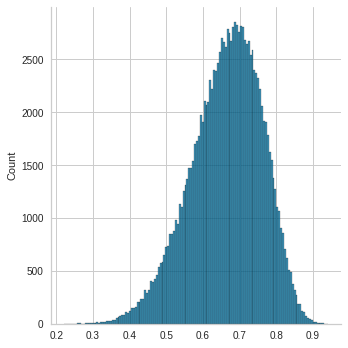

In [330]:
pred_test = np.mean(pred_tests, 0)
df_test['pred'] = pred_test

_ = sns.displot(pred_test)

In [331]:
final_sub = df_test[['ID', 'pred']].copy()
final_sub.to_csv('submission.csv', index=False)

In [332]:
final_sub

,ID,pred
0,2023_1101_1102,0.635916
1,2023_1101_1103,0.775972
2,2023_1101_1104,0.779794
3,2023_1101_1105,0.683898
4,2023_1101_1106,0.757766
...,...,...
130678,2023_3474_3476,0.650699
130679,2023_3474_3477,0.572379
130680,2023_3475_3476,0.730909
130681,2023_3475_3477,0.664313


Done ! 

# AutoML

여기서부터가 가져온 게 아니라 실제로 만든 것, AutoML로 모델 구축

In [333]:
!pip install --use-deprecated=legacy-resolver pycaret[full]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [62]:
!pip install numba==0.53

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 22.0 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.37.0
    Uninstalling llvmlite-0.37.0:
      Successfully uninstalled llvmlite-0.37.0
  Attempting uninstall: numba
    Found existing installation: numba 0.54.1
    Uninstalling numba-0.54.1:
      Successfully uninstalled numba-0.54.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
explainerdashboard 0.4.2.1 requires scikit-learn>=1.1, but you have scikit-learn 0.23.2 which is incompatible.


In [63]:
!pip uninstall sklearn -y
!pip install --upgrade sklearn
!pip install scikit-learn==0.2 --user

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=41b999e77a8123f5d05a2694077a49514fd704b34a9676d41b9ad0aaa2dc8c64
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scikit-learn==0.2 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0rc1, 1.2.0, 1.2.

#### Setup

In [334]:
train_df = pd.concat([df[features], df['WinA']],axis=1)

test_df = df_test[features]

In [343]:
df

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,...,wins_y,SeedDiff,WinRatioDiff,GapAvgDiff,FGDiff,FG3Diff,FTDiff,TOmarginDiff,ScoreDiff,WinA
0,2012,138,3116,72,3173,55,6,11,0.741935,9.903226,...,23,-5,-0.051168,-1.096774,-0.007000,-0.005874,-0.106095,0.035632,17,1
1,2012,138,3163,83,3341,47,1,16,0.878788,30.575758,...,13,-15,0.362659,31.124145,0.095833,0.056283,0.061476,-2.764069,36,1
2,2012,138,3177,59,3140,55,7,10,0.687500,7.000000,...,25,-3,-0.118952,-6.322581,-0.001849,-0.009989,-0.005180,-1.268145,4,1
3,2012,138,3211,86,3353,73,11,6,0.838710,13.645161,...,21,5,0.129032,7.580645,0.041194,0.031463,0.055690,-2.758065,13,1
4,2012,138,3243,67,3343,64,8,9,0.593750,1.093750,...,24,-1,-0.263393,-18.406250,-0.047062,-0.032161,-0.013315,1.232143,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,2022,146,1274,50,1242,76,10,1,0.696970,3.787879,...,23,9,-0.126560,-6.653298,-0.002013,-0.009161,0.019261,-3.850267,-26,0
1299,2022,146,1389,49,1314,69,15,8,0.620690,3.931034,...,18,7,-0.106583,-1.856844,-0.028112,-0.016148,-0.080351,-1.770115,-20,0
1300,2022,152,1437,65,1242,81,2,1,0.787879,9.545455,...,26,1,-0.035651,-0.895722,-0.040517,0.008975,0.088658,-2.274510,-16,0
1301,2022,152,1181,77,1314,81,2,8,0.823529,13.029412,...,28,-6,0.096257,7.241533,0.034826,-0.003923,-0.038795,-2.254902,-4,0


오류 생기면 런타임 재시작

In [340]:
#https://pycaret.readthedocs.io/en/latest/api/regression.html

from pycaret.classification import *

reg_test_1 = setup(data=train_df,   # df 설정
                   target='WinA', # Target 설정
                   train_size= 0.7, # size 설정
                   fold=5,
                   normalize = True,
                   transformation = True,
                   pca = False,
                   #use_gpu = True,
                   #ordinal_features = {'key' : [i for i in range(12)]}'# Fold 설정
                   )


,Description,Value
0,session_id,8696
1,Target,WinA
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(2606, 14)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                                                  random_state_quantile=8696,
                                                  target='WinA')),
                ('binn', 'pas

In [341]:
#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

from sklearn.metrics import brier_score_loss

add_metric('Brier', 'Brier', brier_score_loss, greater_is_better=False, target="pred_proba")

Name                                                             Brier
Display Name                                                     Brier
Score Function           <function brier_score_loss at 0x7f769cd46f70>
Scorer               make_scorer(brier_score_loss, greater_is_bette...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: Brier, dtype: object

### Blended Model

In [342]:
#Brier score가 높은 모델 3개를 앙상블 (제외된 2개의 모델은 Brier score를 구할 수 없어서 제외함함)

custom_model = compare_models(fold = 5, 
                              sort = 'Brier', 
                              n_select = 3, 
                              exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,TT (Sec)
lr,Logistic Regression,0.7204,0.8218,0.7192,0.7236,0.7209,0.4407,0.4412,0.5119,0.1732,1.564
lda,Linear Discriminant Analysis,0.7182,0.8210,0.7181,0.7208,0.7186,0.4363,0.4374,0.5218,0.1762,0.028
catboost,CatBoost Classifier,0.7160,0.8106,0.7159,0.7189,0.7168,0.4319,0.4326,0.5328,0.1798,6.046
rf,Random Forest Classifier,0.7138,0.8047,0.6930,0.7257,0.7080,0.4277,0.4289,0.5347,0.1801,0.736
gbc,Gradient Boosting Classifier,0.7204,0.8060,0.7235,0.7219,0.7218,0.4407,0.4417,0.5360,0.1818,0.788
et,Extra Trees Classifier,0.7110,0.8023,0.7115,0.7131,0.7120,0.4221,0.4224,0.6277,0.1826,0.340
lightgbm,Light Gradient Boosting Machine,0.6973,0.7865,0.6963,0.7002,0.6979,0.3946,0.3950,0.6296,0.2041,0.310
knn,K Neighbors Classifier,0.6973,0.7662,0.6920,0.7027,0.6966,0.3947,0.3955,1.9370,0.2044,0.122
xgboost,Extreme Gradient Boosting,0.6897,0.7734,0.6931,0.6919,0.6919,0.3793,0.3799,0.7278,0.2234,0.542
ada,Ada Boost Classifier,0.7116,0.7979,0.7115,0.7143,0.7124,0.4232,0.4237,0.6657,0.2369,0.320


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=8696, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), <catboost.core.CatBoostClassifier object at 0x7f7652e4e5b0>]
INFO:logs:compare_models() succesfully completed......................................


In [66]:
# 가장 좋은 모델들들에 대해 튜닝

tuned_top = [tune_model(i) for i in custom_model]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
Fold,,,,,,,,,
0,0.7271,0.8136,0.7482,0.7169,0.7322,0.4542,0.4546,0.5297,0.1765
1,0.7304,0.8241,0.7306,0.7288,0.7297,0.4607,0.4607,0.5061,0.1712
2,0.7437,0.8289,0.7506,0.7399,0.7452,0.4873,0.4874,0.4993,0.1697
3,0.7183,0.7991,0.7094,0.7217,0.7155,0.4365,0.4366,0.5321,0.1832
4,0.7739,0.8577,0.7676,0.7770,0.7722,0.5478,0.5478,0.4660,0.1555
Mean,0.7386,0.8247,0.7413,0.7368,0.7390,0.4773,0.4774,0.5066,0.1712
Std,0.0194,0.0194,0.0198,0.0215,0.0191,0.0388,0.0388,0.0240,0.0092


INFO:logs:create_model_container: 33
INFO:logs:master_model_container: 33
INFO:logs:display_container: 8
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=5, max_features=1.0,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0005, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=7,
                       min_weight_fraction_leaf=0.0, n_estimators=280,
                       n_jobs=-1, oob_score=False, random_state=2368, verbose=0,
                       warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


In [67]:
# Brier score

blended_custom = blend_models(estimator_list = tuned_top,
                              fold = 5,
                              optimize = 'logloss')

pred_holdout_custom = predict_model(blended_custom)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
Fold,,,,,,,,,
0,0.7271,0.8192,0.7530,0.7149,0.7335,0.4542,0.4548,0.5145,0.1736
1,0.7304,0.8268,0.7330,0.7277,0.7304,0.4607,0.4607,0.5043,0.1705
2,0.7533,0.8351,0.7554,0.7518,0.7536,0.5067,0.5067,0.4945,0.1663
3,0.7267,0.8014,0.7143,0.7320,0.7230,0.4534,0.4536,0.5333,0.1828
4,0.7739,0.8598,0.7700,0.7756,0.7728,0.5478,0.5478,0.4640,0.1535
Mean,0.7423,0.8285,0.7451,0.7404,0.7427,0.4845,0.4847,0.5021,0.1694
Std,0.0186,0.0192,0.0194,0.0212,0.0182,0.0373,0.0371,0.0230,0.0096


INFO:logs:create_model_container: 34
INFO:logs:master_model_container: 34
INFO:logs:display_container: 9
INFO:logs:VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.066, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=2368,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         prio

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier
0,Voting Classifier,0.7452,0.836,0.7632,0.7383,0.7506,0.4903,0.4906,0.4926,0.1655


In [68]:
#최종 모델
final_model_custom = finalize_model(blended_custom)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=0.066, class_weight={},
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=2368,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('lda',
                              LinearDiscriminantAnalysis(n_components=None,
                                                         priors=None,
                               

In [78]:
#
prep_pipe = get_config("prep_pipe")

prep_pipe.steps.append(['trained_model', final_model_custom])

predictions = predict_model(prep_pipe,
                            data=test_df,
                            raw_score=True)

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=prep_pipe)
INFO:logs:Global variable: prep_pipe returned as Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                                                                      max_features=1.0,
                                                                      max

ValueError: ignored

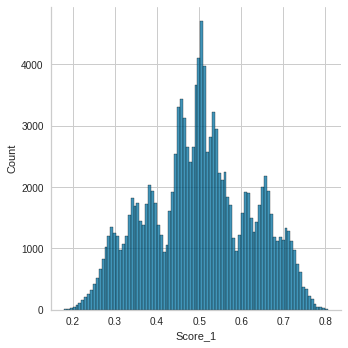

In [79]:
df_test_after_AutoML = df_test.copy()

df_test['pred'] = predictions['Score_1']

_ = sns.displot(predictions['Score_1'])

#### 최종 제출 파일

In [80]:
final_sub_after_AutoML = df_test_after_AutoML[['ID', 'pred']].copy()

final_sub_after_AutoML.to_csv('submission.csv', index=False)

### Test : 2022년도로 Test

In [72]:
df_val = df[df['Season'] == 2022]

In [73]:
df_val

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,WinRatioA,GapAvgA,WinRatioB,GapAvgB,SeedDiff,WinRatioDiff,GapAvgDiff,ScoreDiff,WinA
1386,2022,135,3173,88,3177,57,11,11,0.833333,10.766667,0.687500,10.000000,0,0.145833,0.766667,31,1
1387,2022,135,3224,55,3230,51,16,16,0.678571,3.392857,0.407407,-3.518519,0,0.271164,6.911376,4,1
1388,2022,136,3255,74,3291,70,16,16,0.656250,4.312500,0.538462,0.423077,0,0.117788,3.889423,4,1
1389,2022,136,3283,61,3199,50,11,11,0.766667,10.033333,0.566667,4.133333,0,0.200000,5.900000,11,1
1390,2022,137,3124,89,3218,49,2,15,0.818182,16.515152,0.689655,1.482759,-13,0.128527,15.032393,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2950,2022,146,1274,50,1242,76,10,1,0.696970,3.787879,0.823529,10.441176,9,-0.126560,-6.653298,-26,0
2951,2022,146,1389,49,1314,69,15,8,0.620690,3.931034,0.727273,5.787879,7,-0.106583,-1.856844,-20,0
2952,2022,152,1437,65,1242,81,2,1,0.787879,9.545455,0.823529,10.441176,1,-0.035651,-0.895722,-16,0
2953,2022,152,1181,77,1314,81,2,8,0.823529,13.029412,0.727273,5.787879,-6,0.096257,7.241533,-4,0


In [74]:
prediction = prep_pipe.predict_proba(df_val[features])

i, j = [], []
for row in prediction:
  i.append(row[0])
  j.append(row[1])

len(i), len(j)

df_val['pred'] = j

df_val['WinA_pred'] = prep_pipe.predict(df_val[features])

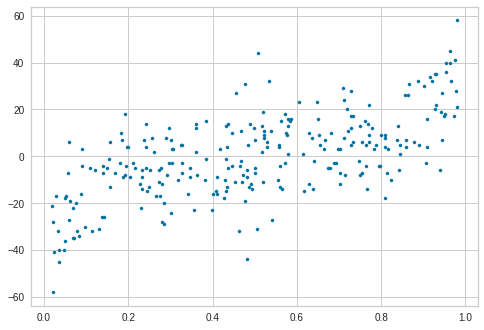

In [75]:
plt.scatter(df_val['pred'], df_val['ScoreDiff'].values, s=10)

In [76]:
# 2022년 대상으로 할 시 약 0.188 정도 나옴옴

brier_score_loss(df_val['WinA'], df_val['pred'])

0.18603305952803395

1. 이전 솔루션을 볼 때 모든 변수를 쓸 필요는 없음 (EDA 안 한 경우도 많음)

2. Baseline은 2021년 2등 솔루션을 토대로 만들어졌으며 다음과 같은 특징을 가짐
- 각년도마다 모델을 만들고 각년도별 모델로 2023년을 예측 후 평균한 것을 최종 score로 산정
- MinMax (정규화), 로지스틱 회귀 적용
- 교차검증 점수는 0.169이긴한데 교차검증 방식 자체가 특이해서 (연도별 brier의 평균) 참고만 할 것
- 2016~2021년 데이터만을 학습에 사용함.

3. 대회 규칙이 굉장히 특이하니 참고할 것
- 남녀 리그를 모두 예측해야하며 적절히 모델을 만들어서 낼 것
(남녀 리그별 모델을 각각 만들어 2개의 모델 만들어서 각각 예측하거나 남녀 통합해서 하나의 모델만 만들 수 있음)
- Brier Score라는 낯선 평가 방식을 사용함. (나도 처음 봤음) 0~0.25의 범위를 가지며 0으로 갈수록 의미 있는 모델
- Test set 만드는 방식이 굉장히 특이하니 Baseline 그대로 가져오는 것을 추천함

* Test set 만드는 방식
1. 일반적인 상식 : 약 300개의 팀이 조 그룹 편성 이후 각 팀 간의 승률 계산
2. 이 대회의 방식 : 조 그룹 편성 이전부터 300개 팀 간의 승률 계산
3. Test set 만드는 방식이 상식 밖이라 Baseline 코드를 그대로 수용하는거 추천

4. AutoML로 한 것
- Baseline과 달리 모든년도의 데이터로 학습했으며, 각년도별 모델 X
- Metric으로 Brier Score 추가함
- 성능이 좋은 모델 3개를 하이퍼파라미터 튜닝 후 앙상블한 기법(voting)
- Brier score 결과가 0.167이지만 2와 점수 산정하는 방식이 달라 큰 의미는 없음



# Woman / Man 분화

## Man

In [124]:
train_man = df[df['TeamIdA'].astype('str').str.contains('^1',regex= True)]

train_woman = df[df['TeamIdA'].astype('str').str.contains('^3',regex= True)]

test_man = df_test[df_test['TeamIdA'].astype('str').str.contains('^1',regex= True)]

test_woman = df_test[df_test['TeamIdA'].astype('str').str.contains('^3',regex= True)]

In [135]:
train_df_man = pd.concat([train_man[features], train_man['WinA']],axis=1)

test_df_man = test_man[features]

In [136]:
train_df_woman = pd.concat([train_woman[features], train_woman['WinA']],axis=1)

test_df_woman = test_woman[features]

In [143]:
#https://pycaret.readthedocs.io/en/latest/api/regression.html

from pycaret.classification import *

reg_test_1 = setup(data=train_df_man,   # df 설정
                   target='WinA', # Target 설정
                   train_size= 0.7, # size 설정
                   fold=5,
                   normalize = True,
                   transformation = True,
                   pca = True,
                   #use_gpu = True,
                   #ordinal_features = {'key' : [i for i in range(12)]}'# Fold 설정
                   )

#logloss 적용 및 predict_proba로 제출하기 위해 metric 추가
add_metric('logloss', 'LogLoss', log_loss, greater_is_better=False, target="pred_proba")

from sklearn.metrics import brier_score_loss

add_metric('Brier', 'Brier', brier_score_loss, greater_is_better=False, target="pred_proba")

,Description,Value
0,session_id,1005
1,Target,WinA
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(1338, 14)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,2
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='WinA',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_strateg...
                ('dummy', Dummify(target='WinA')),
                ('fix_perfect', Remove_100(target='WinA')),
                ('clean_names', Clean_Colum_Names()),
         

Name                                                             Brier
Display Name                                                     Brier
Score Function           <function brier_score_loss at 0x7fc5ed591f70>
Scorer               make_scorer(brier_score_loss, greater_is_bette...
Target                                                      pred_proba
Args                                                                {}
Greater is Better                                                False
Multiclass                                                        True
Custom                                                            True
Name: Brier, dtype: object

In [144]:
#Brier score가 높은 모델 3개를 앙상블 (제외된 2개의 모델은 Brier score를 구할 수 없어서 제외함)

custom_model = compare_models(fold = 5, 
                              sort = 'Brier', 
                              n_select = 3, 
                              exclude=['svm','ridge'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,LogLoss,Brier,TT (Sec)
lr,Logistic Regression,0.6539,0.7464,0.6611,0.6589,0.6598,0.3075,0.3076,0.5955,0.2056,0.050
lda,Linear Discriminant Analysis,0.6507,0.7414,0.6526,0.6573,0.6548,0.3012,0.3014,0.6029,0.2086,0.028
rf,Random Forest Classifier,0.6432,0.7202,0.6316,0.6563,0.6432,0.2866,0.2873,0.6137,0.2136,0.520
catboost,CatBoost Classifier,0.6539,0.7280,0.6632,0.6612,0.6609,0.3075,0.3088,0.6195,0.2138,13.182
gbc,Gradient Boosting Classifier,0.6432,0.7233,0.6442,0.6531,0.6477,0.2863,0.2874,0.6202,0.2158,0.626
et,Extra Trees Classifier,0.6357,0.7097,0.6316,0.6468,0.6379,0.2715,0.2728,0.6287,0.2182,0.282
ada,Ada Boost Classifier,0.6485,0.6972,0.6505,0.6580,0.6531,0.2969,0.2982,0.6735,0.2405,0.216
nb,Naive Bayes,0.6592,0.6960,0.6863,0.6588,0.6716,0.3178,0.3187,0.7357,0.2438,0.030
lightgbm,Light Gradient Boosting Machine,0.6496,0.7117,0.6526,0.6565,0.6544,0.2991,0.2993,0.7829,0.2486,0.514
dummy,Dummy Classifier,0.5075,0.5000,1.0000,0.5075,0.6733,0.0000,0.0000,0.6930,0.2499,0.016


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1005, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001), RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0